# Batch Structure Optimization

With MatterSimCalculator, one can only predict the properties of a single structure at a time, which is not efficient for large-scale calculations to effectively utilize the GPU.

A more efficient way to predict the properties of multiple structures is using the Potential class.

In [1]:
import torch
import time
import os
import sys
sys.path.append(os.path.abspath(".."))

import numpy as np
from ase.build import bulk
from ase.units import GPa
from mattersim.applications.batch_relax import BatchRelaxer
from mattersim.forcefield.potential import Potential
from mattersim.datasets.utils.build import build_dataloader
# from mattersim.forcefield.potential import MatterSimCalculator
# from mattersim.applications.relax import Relaxer

from utils.visualisation import plot_potential, plot_relaxation

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running MatterSim on {device}")

Running MatterSim on cpu


### Available Models

|                    | mattersim-v1.0.0-1M   | mattersim-v1.0.0-5M     |
| ------------------ | --------------------- | ----------------------- |
| Training Data Size | 3M                    | 6M                      |
| Model Parameters   | 880K                  | 4.5M                    |

In [3]:
# load the model
model = 5
potential = Potential.from_checkpoint(load_path=f"MatterSim-v1.0.0-{model}M.pth", device=device)

2025-02-06 01:50:57.779 | INFO     | mattersim.forcefield.potential:from_checkpoint:891 - Loading the pre-trained mattersim-v1.0.0-5M.pth model
2025-02-06 01:51:05.730 | INFO     | mattersim.applications.batch_relax:step_batch:126 - Relaxed 100 structures.
2025-02-06 01:51:10.405 | INFO     | mattersim.applications.batch_relax:step_batch:126 - Relaxed 200 structures.
2025-02-06 01:51:15.475 | INFO     | mattersim.applications.batch_relax:step_batch:126 - Relaxed 300 structures.
2025-02-06 01:51:20.396 | INFO     | mattersim.applications.batch_relax:step_batch:126 - Relaxed 400 structures.
2025-02-06 01:51:25.518 | INFO     | mattersim.applications.batch_relax:step_batch:126 - Relaxed 500 structures.
2025-02-06 01:51:30.563 | INFO     | mattersim.applications.batch_relax:step_batch:126 - Relaxed 600 structures.
2025-02-06 01:51:35.380 | INFO     | mattersim.applications.batch_relax:step_batch:126 - Relaxed 700 structures.
2025-02-06 01:51:39.848 | INFO     | mattersim.applications.batch

/usr/local/lib/python3.12/dist-packages/mattersim/forcefield/potential.py:896: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(load_path, map_location=

### Set up structures and push to dataloader

In [4]:
# set up the structure
si = bulk("Si", "diamond", a=5.43)

# replicate the structures to form a list
structures = [si] * 1000

# build the dataloader that is compatible with MatterSim
dataloader = build_dataloader(structures, only_inference=True)

#### Make predictions

In [5]:
# make predictions
predictions = potential.predict_properties(dataloader, include_forces=True, include_stresses=True)

# len(predictions) = 3
print(f"\nTotal energy in eV: {predictions[0]}")
print(f"\nForces in eV/Angstrom: {predictions[1]}")
print(f"\nStresses in GPa: {predictions[2]}")

# By default, MatterSim potential.predict_properties predicts stress tensors in GPa.
# To convert the stress tensor, multiply the stress tensor by the conversion factor GPa.
print(f"\nStresses in eV/A^3: {np.array(predictions[2])*GPa}")


Total energy in eV: [-10.814008712768555, -10.814008712768555, -10.814007759094238, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.814008712768555, -10.81400871

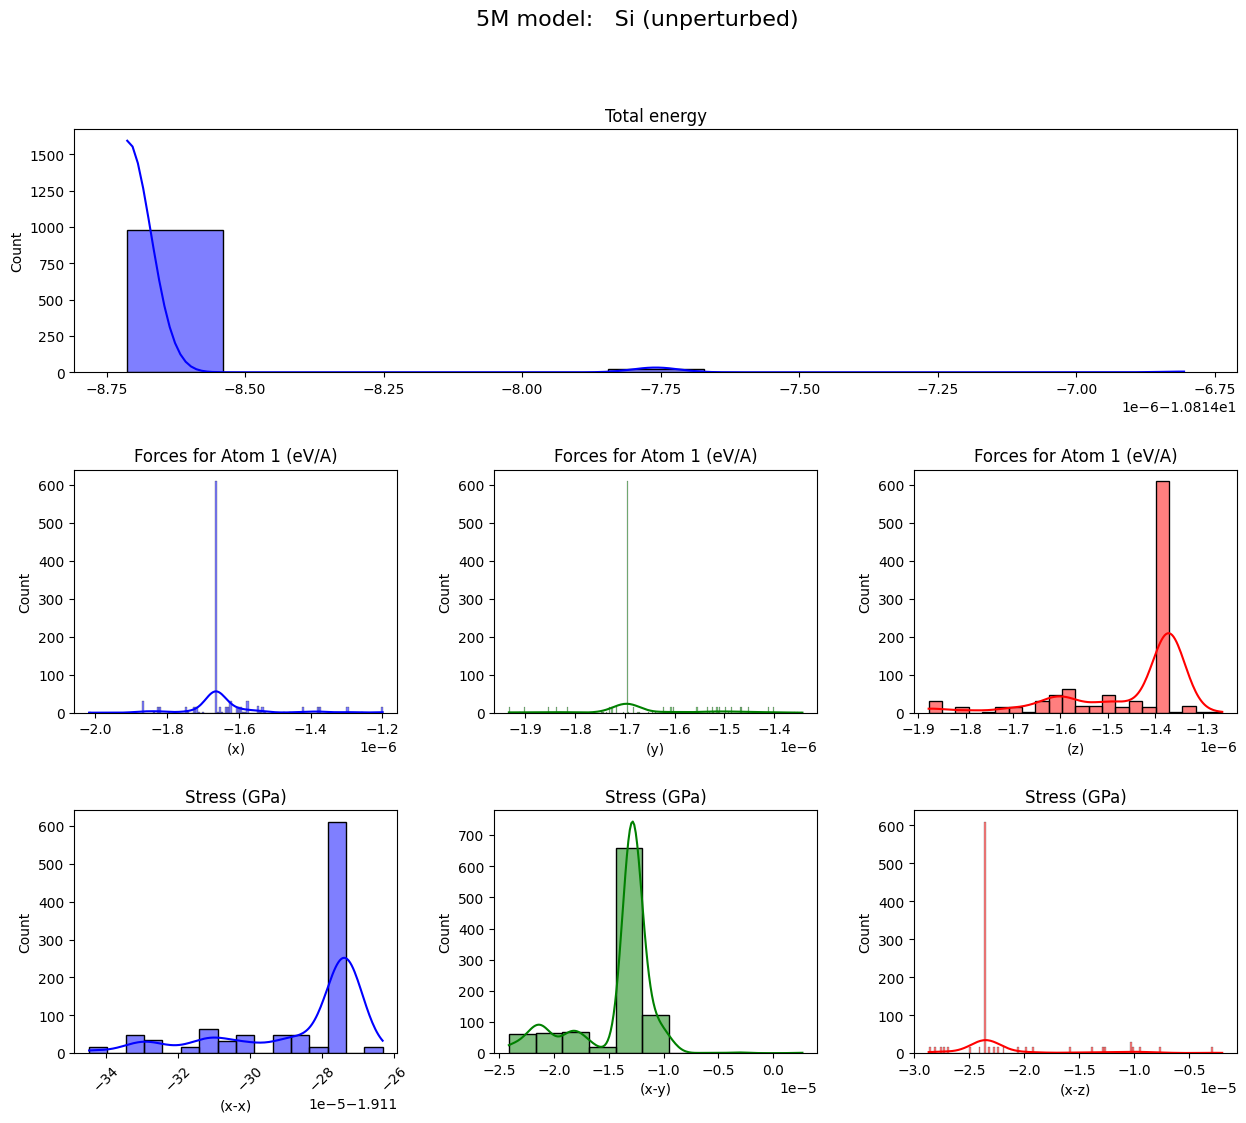

In [6]:
plot_potential(predictions, f"{model}M model:   Si (unperturbed)")

#### Relax structure

In [7]:
# initialize the batch relaxer with a EXPCELLFILTER for cell relaxation and a FIRE optimizer
relaxer = BatchRelaxer(potential, fmax=0.01, filter="EXPCELLFILTER", optimizer="FIRE")

In [8]:
# Run the relaxation, takes input list & returns dict
start = time.time()
relaxation_trajectories = relaxer.relax(structures)
print(f"\nTime taken for relaxation: {time.time()-start:.2f}s")

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/mattersim/applications/batch_relax.py:80: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(DummyBatchCalculator())


100%|██████████| 1000/1000 [00:47<00:00, 21.03it/s]

Time taken for relaxation: 47.56s


In [9]:
for traj in relaxation_trajectories.values():
    last_relaxation = traj[-1]
    print(last_relaxation)
    break
last_relaxation.info

Atoms(symbols='Si2', pbc=True, cell=[[-6.703756435496791e-08, 2.734018987455058, 2.7340190486364224], [2.7340191224104355, -3.483275216624425e-08, 2.734019016431611], [2.734019266959598, 2.7340190997994083, -1.793819092584575e-07]], forces=...)


{'structure_index': 0,
 'total_energy': -10.818990707397461,
 'stress': array([[-1.2596907e-02, -2.8729253e-05,  1.8899989e-05],
        [-2.8908637e-05, -1.2573335e-02, -1.5125830e-05],
        [ 1.8846098e-05, -1.5191633e-05, -1.2594692e-02]], dtype=float32)}

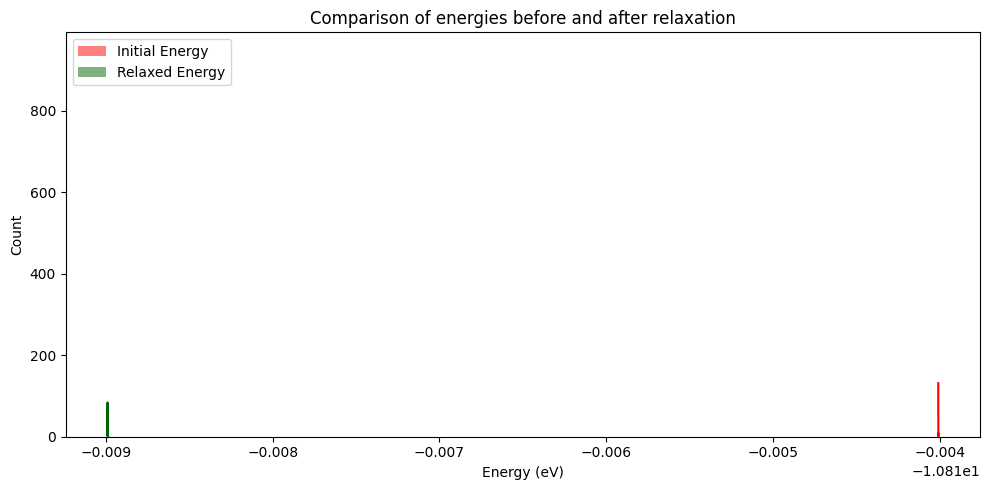

In [10]:
plot_relaxation(relaxation_trajectories)

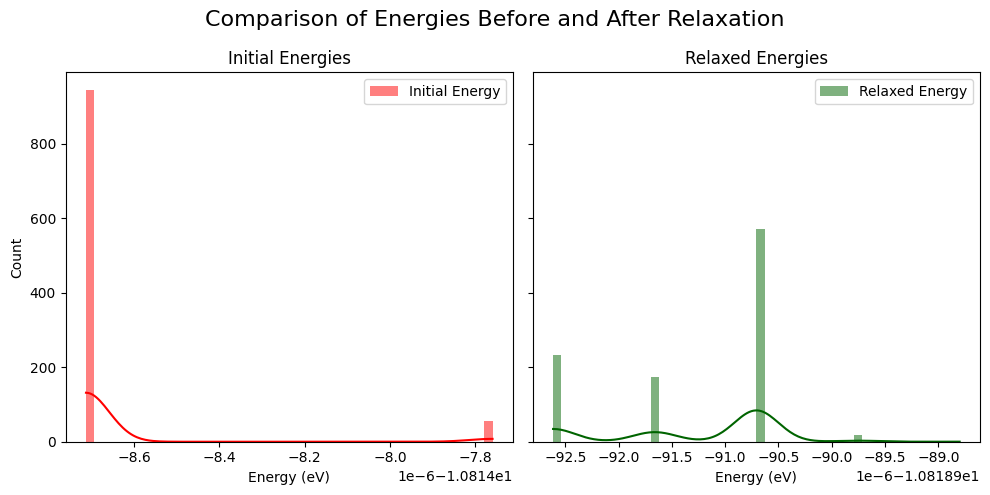

In [11]:
plot_relaxation(relaxation_trajectories, split = True)

### Set up perturbed structures

In [12]:
# demo use rattle to perturb
si = bulk("Si", "diamond", a = 2)
print(f"Before perturbation:\n{si.positions}\n")
si.rattle(stdev=0.1)
print(f"After perturbation:\n{si.positions}")

Before perturbation:
[[0.  0.  0. ]
 [0.5 0.5 0.5]]

After perturbation:
[[ 0.04967142 -0.01382643  0.06476885]
 [ 0.65230299  0.47658466  0.4765863 ]]


In [13]:
perturbed_structures = []
for _ in range(1000):
    si = bulk("Si", 'diamond', a = 5.43)
    si.rattle(stdev=np.random.random())
    perturbed_structures.append(si)                    

In [14]:
print(perturbed_structures[0].positions)
print(perturbed_structures[1].positions)

[[ 0.1163079  -0.03237522  0.15165925]
 [ 1.71412445  1.30267191  1.30267575]]
[[ 0.34838527 -0.09697579  0.45427565]
 [ 2.42572237  1.19326955  1.19328107]]


In [15]:
perturbed_dataloader = build_dataloader(perturbed_structures, only_inference=True)

#### Make predictions

In [16]:
perturbed_predictions = potential.predict_properties(perturbed_dataloader,include_forces=True, include_stresses=True )

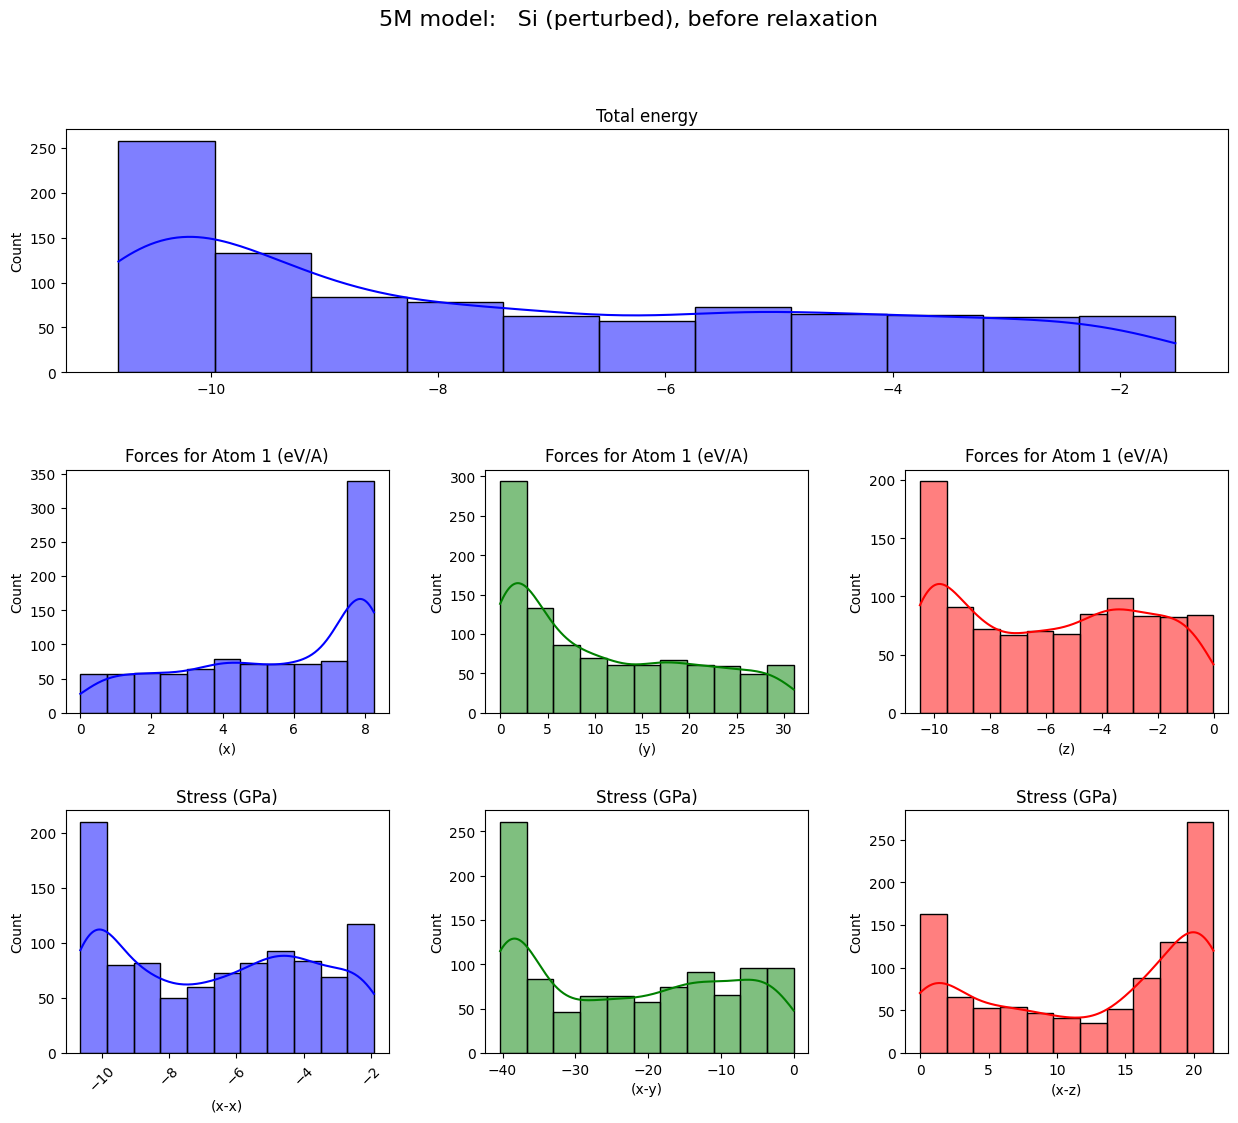

In [17]:
plot_potential(perturbed_predictions, f"{model}M model:   Si (perturbed), before relaxation")

#### Relax structure

In [18]:
# Run the relaxation
start = time.time()
perturbed_relaxation_trajectories = relaxer.relax(perturbed_structures)
print(f"\nTime taken for relaxation: {time.time()-start:.2f}s")

  0%|          | 0/1000 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/mattersim/applications/batch_relax.py:80: FutureWarning: Please use atoms.calc = calc
  atoms.set_calculator(DummyBatchCalculator())


100%|██████████| 1000/1000 [03:22<00:00,  4.93it/s]

Time taken for relaxation: 202.70s


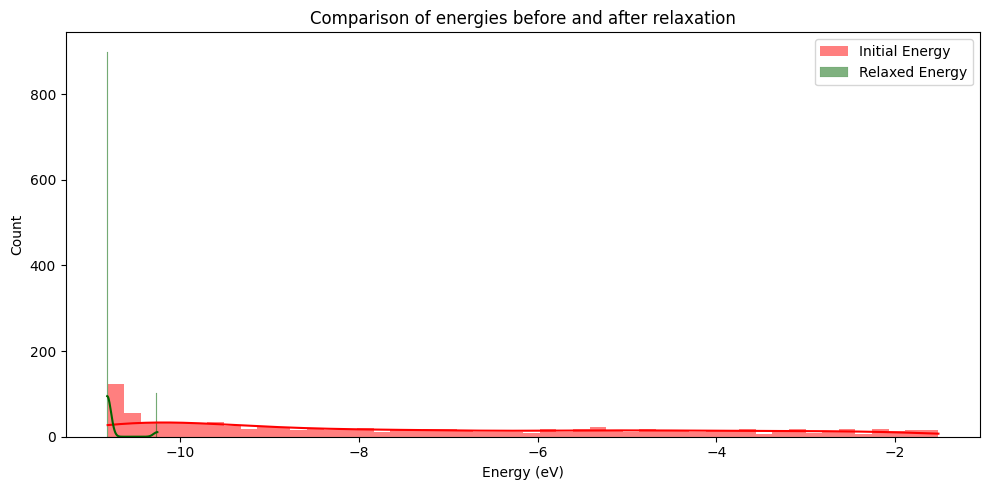

In [19]:
plot_relaxation(perturbed_relaxation_trajectories)

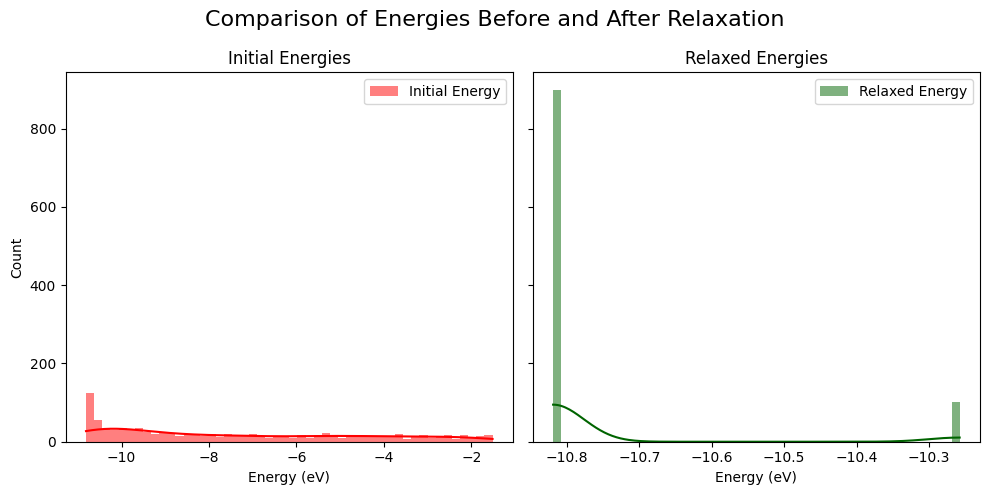

In [20]:
plot_relaxation(perturbed_relaxation_trajectories, split = True)